In [7]:
import numpy as np
from scipy import integrate
import numdifftools as nd
from scipy.optimize.nonlin import newton_krylov
import scipy.sparse.linalg as spla
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

In [8]:
''' inputs '''
T=3.0 # horizon length 
N=1 # number of cars 
u_max=1.0 # free flow speed
rho_jam=1.0 # jam density
L=N # road length
CFL=0.75    # CFL<= 1
rho_a=0.05; rho_b=0.95; gama=0.1
# rho_a=0.2; rho_b=0.8; gama=0.15*L
costf="LWR"
Error_list=[]
Nx_list=[]
beta=1
mu=0.5

In [9]:
''' functions '''
def U(rho): # Greenshields desired speed
    return u_max*(1-rho/rho_jam)

def f_mfg(u,r):
    if costf=="LWR":
        return 0.5*((U(r)-u)**2) # MFG-LWR
    elif costf=="Sep":
        return 0.5*((u/u_max)**2)-(u/u_max)+(r/rho_jam) # MFG-Separable
    elif costf=="NonSep":
        return 0.5*((u/u_max)**2)-(u/u_max)+((u*r)/(u_max*rho_jam)) # MFG-NonSeparable

def f_star_p(p,r): # 0<=u<=u_max
    if costf=="LWR":
        return U(r)-p # MFG-LWR
    elif costf=="Sep":
        return max(min(u_max*(1-p*u_max),u_max),0) # MFG-Separable
    elif costf=="NonSep":
        return max(min(u_max*(1-r/rho_jam-u_max*p),u_max),0) # MFG-NonSeparable
    
def f_star(p,r): # p=Vx
    if costf=="LWR":
        return -0.5*(p**2)+U(r)*p # MFG-LWR
    elif costf=="Sep":
        return f_star_p(p,r)*p+f_mfg(f_star_p(p,r),r) # MFG-Separable
    elif costf=="NonSep":
        return f_star_p(p,r)*p+f_mfg(f_star_p(p,r),r) # MFG-NonSeparable

def integral(a,b): 
    x2 = lambda x: rho_int(x)
    I=integrate.quad(x2, a, b)
    return I[0]

def rho_int(s): # initial density
    return rho_a+(rho_b-rho_a)*np.exp(-0.5*((s-0.5*L)/gama)**2) # 0<=rho<=rho_jam

def VT(a): # Terminal cost
    return 0.0

def F(w):
    # FF=[F_rho,F_u,F_V,F_rho_int,F_V_ter], F_rho:0->Nt*Nx-1, F_u:Nt*Nx->2*Nt*Nx-1, F_V:2*Nt*Nx->3*Nt*Nx-1, F_rho_int:3*Nt*Nx->3*Nt*Nx+Nx-1, F_V_ter:3*Nt*Nx+Nx->3*Nt*Nx+2*Nx-1
    FF=np.zeros(3*Nt*Nx+2*Nx)
    for n in range(0,Nt):
        # F_rho , F[0]->F[Nt-1] ************** 1
        FF[n]=w[n+1]-w[n]+(dt/dx)*w[n]*w[n+(Nt+1)*Nx]+ep1*(w[n+Nt+1]-2*w[n])
        # F_rho , F[Nt*Nx-Nt]->F[Nt*Nx-1] ********** 3
        FF[Nt*(Nx-1)+n]=w[(Nt+1)*(Nx-1)+n+1]-w[(Nt+1)*(Nx-1)+n]-(dt/dx)*w[(Nt+1)*(Nx-1)+n]*w[(Nt+1)*Nx+(Nx-1)*Nt+n]+ep1*(-2*w[(Nt+1)*(Nx-1)+n]+w[(Nt+1)*(Nx-2)+n])
        # F_u , F[Nt*Nx]->F[Nt*Nx+Nt-1] *********** 4
        FF[Nt*Nx+n]=w[(Nt+1)*Nx+n]-beta*f_star_p(w[(2*Nt+1)*Nx+n+1]/dx,w[n])
        # F_u , F[2*Nt*Nx-Nt]->F[2*Nt*Nx-1] ********* 6
        FF[2*Nt*Nx-Nt+n]=w[(Nt+1)*Nx+(Nx-1)*Nt+n]-beta*f_star_p((w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])/dx,w[(Nx-1)*(Nt+1)+n])
        # F_V , F[2*Nt*Nx]->F[2*Nt*Nx+Nt-1] *********** 7
        FF[2*Nt*Nx+n]=w[(2*Nt+1)*Nx+n+1]-w[(2*Nt+1)*Nx+n]+beta*dt*f_star(w[(2*Nt+1)*Nx+n+1]/dx,w[n])+ep2*(w[(2*Nt+1)*Nx+Nt+n+2]-2*w[(2*Nt+1)*Nx+n+1])
        # F_V , F[3*Nt*Nx-Nt]->F[3*Nt*Nx-1] ********** 9
        FF[3*Nt*Nx-Nt+n]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n]+beta*dt*f_star((w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])/dx,w[(Nx-1)*(Nt+1)+n])+ep2*(-2*w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])
    for j in range(2,Nx):
        for n in range(0,Nt):
            # F_rho , F[Nt]->F[Nt*Nx-Nt-1] ************ 2
            FF[(j-1)*Nt+n]=w[(j-1)*(Nt+1)+n+1]-w[(j-1)*(Nt+1)+n]+(dt/dx)*(w[(j-1)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-1)*Nt+n]-w[(j-2)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-2)*Nt+n])+ep1*(w[j*(Nt+1)+n]-2*w[(j-1)*(Nt+1)+n]+w[(j-2)*(Nt+1)+n])
            # F_u , F[Nt*Nx+Nt]->F[2*Nt*Nx-Nt-1] *********** 5
            FF[(j-1)*Nt+Nt*Nx+n]=w[(Nt+1)*Nx+(j-1)*Nt+n]-beta*f_star_p((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])
            # F_V , F[2*Nt*Nx+Nt]->F[3*Nt*Nx-Nt-1] ********* 8
            FF[(j-1)*Nt+2*Nt*Nx+n]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]+beta*dt*f_star((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])+ep2*(w[(2*Nt+1)*Nx+j*(Nt+1)+n+1]-2*w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])
        # F_rho_int , F[3*Nt*Nx+1]->F[3*Nt*Nx+Nx-2] ********** 11
        FF[3*Nt*Nx+j-1]=w[(j-1)*(Nt+1)]-(1/dx)*integral(x[j-1],x[j])
        # F_V_ter , F[3*Nt*Nx+Nx+1]->F[3*Nt*Nx+2*Nx-2] ********* 14
        FF[3*Nt*Nx+Nx+j-1]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]-VT(x[j])
    # F_rho_int , F[3*Nt*Nx] ********* 10
    FF[3*Nt*Nx]=w[0]-(1/dx)*integral(x[0],x[1])
    # F_rho_int , F[3*Nt*Nx+Nx-1] ********* 12
    FF[3*Nt*Nx+Nx-1]=w[(Nx-1)*(Nt+1)]-(1/dx)*integral(x[Nx-1],x[Nx])
    # F_V_ter , F[3*Nt*Nx+Nx] *********** 13 
    FF[3*Nt*Nx+Nx]=w[(2*Nt+1)*Nx+Nt]-VT(x[1])
    # F_V_ter , F[3*Nt*Nx+2*Nx-1] ************** 15
    FF[3*Nt*Nx+2*Nx-1]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+Nt]-VT(x[Nx])
    
    return FF


def get_preconditioner(a):
    beta=0 # Ignoring the forward-backward coupling  parts
    Jac=nd.Jacobian(F)
    J1=Jac(a)
    # the *incomplete LU* decomposition
    J1_ilu = spla.spilu(J1)
    # matrix-vector product -> LinearOperator 
    M_x = lambda r: J1_ilu.solve(r)
    M = spla.LinearOperator(J1.shape, M_x)

    return M
    

def interpol(Nt,Nt_mul,Nx,Nx_mul,w): # 1D interpolation
    
    """" Go from a coarse grid Nt*Nx to a finer grid spacing (Nt_mul*Nt)*(Nx_mul*Nx) """""

    n=w.shape[0] # n=3Nt*Nx+2Nx
    i = np.indices(w.shape)[0]/(n-1)  # [0, ..., 1]
    new_n = 3*(Nt_mul*Nt)*(Nx_mul*Nx)+2*(Nx_mul*Nx)
    print('n={n}, new_n={new_n}'.format(n=n,new_n=new_n))
    new_i = np.linspace(0, 1, new_n)
    new_w=griddata(i, w, new_i, method="cubic")  # method{‘linear’, ‘nearest’, ‘cubic’}
    
    return Nt_mul*Nt, Nx_mul*Nx, new_w

def solution(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,Nt):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,Nt]=sol[(j-1)*(Nt+1)+Nt]
        V[j,Nt]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
    for n in range(0,Nt+1): # periodic boundary conditions
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
    for n in range(0,Nt):
        u[0,n]=f_star_p(V[0,n+1]/dx,rho[0,n])
        Q[0,n]=rho[0,n]*u[0,n]
#     print("rho=",rho)
#     print("u=",u)
#     print("V=",V)
    return 0

def plotting(text,t,x,rho,u,V,Q,Nx_list,Error_list,fig1,fig2):
    tt, xx = np.meshgrid(t, x)
    fig = plt.figure(figsize=(6, 5), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('density')
    ax.invert_xaxis()
#     ax.text2D(0.05, 0.95, text, transform=ax.transAxes)
    plt.savefig(fig1)

    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
    plt.subplot(2,3,1)
    plt.plot(x,rho[:,0],'b',label='density')
    plt.plot(x,u[:,0],'g',label='speed')
    plt.plot(x,V[:,0],'r',label='Optimal cost')
    plt.legend()
    plt.grid()
    plt.title("t=0.0")
    plt.xlabel('x')
    plt.subplot(2,3,2)
    plt.plot(x,rho[:,int(Nt/4)],'b')
    plt.plot(x,u[:,int(Nt/4)],'g')
    plt.plot(x,V[:,int(Nt/4)],'r')
    plt.grid()
    plt.legend()
    plt.title("t={t}".format(t=round(t[int(Nt/4)],3)))
    plt.xlabel('x')
    plt.subplot(2,3,3)
    plt.plot(x,rho[:,int(Nt/2)],'b')
    plt.plot(x,u[:,int(Nt/2)],'g')
    plt.plot(x,V[:,int(Nt/2)],'r')
    plt.grid()
    plt.legend()
    plt.title("t={t}".format(t=round(t[int(Nt/2)],3)))
    plt.xlabel('x')
    plt.subplot(2,3,4)
    plt.plot(x,rho[:,Nt-1],'b')
    plt.plot(x,u[:,Nt-1],'g')
    plt.plot(x,V[:,Nt-1],'r')
    plt.grid()
    plt.legend()
    plt.title("t={t}".format(t=round(t[Nt-1],3)))
    plt.xlabel('x')
    plt.subplot(2,3,5)
    plt.plot(Nx_list,Error_list)
    plt.xlabel('Spatial grid size')
    plt.ylabel('error')
    plt.grid()
    plt.title("convergence of solution algorithm")
    plt.subplot(2,3,6)
#     plt.figure()
    plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
    plt.xlabel('density')
    plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (T={T})".format(T=T))
    plt.savefig(fig2)
    return 0

def convergence(guess,sol,o):
    rho=np.zeros((Nx+1,Nt+1))
    u=np.zeros((Nx+1,Nt))
    V=np.zeros((Nx+1,Nt+1))
    Q=np.zeros((Nx+1,Nt))
    solution(guess,rho,u,V,Q)
    rho_mfg=np.zeros((Nx+1,Nt+1))
    u_mfg=np.zeros((Nx+1,Nt))
    V_mfg=np.zeros((Nx+1,Nt+1))
    Q_mfg=np.zeros((Nx+1,Nt))
    solution(sol,rho_mfg,u_mfg,V_mfg,Q_mfg)
    error=np.linalg.norm(rho_mfg-rho,ord=o)/np.linalg.norm(rho_mfg,ord=o)+np.linalg.norm(u_mfg-u,ord=o)/np.linalg.norm(u_mfg,ord=o)
    return error

In [10]:
""" solve in coarse grid - use splitting"""
Nx=10; Nt=5 # spatial-temporal grid sizes 
dx=L/Nx # spatial step size
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
""" Non-Viscous part """
# dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
dt=min(T/Nt,CFL*dx/abs(u_max),CFL*(dx**2)/(2*mu)) # regulization 
ep1=-mu*dt/(dx**2) # regulization 
ep2=mu*dt/(dx**2) # V
# ep2=0.0  # V
# ep1=0.0  # rho
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
guess0 = np.zeros(3*Nt*Nx+2*Nx)
t0 = time.process_time()   ###
sol0 = newton_krylov(F, guess0, method='lgmres', verbose=1, inner_M=get_preconditioner(guess0))
t1 = time.process_time()   ###
print("Time spent :",t1-t0)
np.savetxt('Sol0_LWR_T3_N1_mu0.5.dat', sol0)

# print('sol0=',sol1)
""" Error 0 """
error0=convergence(guess0,sol0,1)
Error_list.append(error0)
Nx_list.append(Nx)

dx=0.1, dt=0.008
0:  |F(x)| = 0.0105612; step 1
1:  |F(x)| = 1.24151e-05; step 1
2:  |F(x)| = 1.36145e-11; step 1
Time spent : 8.160700906999999


/home/amal/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [11]:
""" solve in finer grid 1 """
Nt, Nx, guess1=interpol(Nt,2,Nx,2,sol0)
dx=L/Nx # spatial step size
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
""" Non-Viscous part """
# dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size 
dt=min(T/Nt,CFL*dx/abs(u_max),CFL*(dx**2)/(2*mu)) # regulization
ep1=-mu*dt/(dx**2)  # rho
ep2=mu*dt/(dx**2) # regulization 
# ep2=0.0  # V
# ep1=0.0  # rho
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
t0 = time.process_time()   ###
sol1 = newton_krylov(F, guess1, method='lgmres', verbose=1, inner_M=get_preconditioner(guess1))
t1 = time.process_time()   ###
print("Time spent :",t1-t0)
np.savetxt('Sol1_LWR_T3_N1_mu0.5.dat', sol1)

# print('sol0=',sol1)
""" Error 0 """
error1=convergence(guess1,sol1,1)
Error_list.append(error1)
Nx_list.append(Nx)

n=170, new_n=640
dx=0.05, dt=0.002
0:  |F(x)| = 0.00318921; step 1
1:  |F(x)| = 5.66531e-07; step 1
Time spent : 108.223107469


/home/amal/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [14]:
""" solve in finer grid 2 """
Nt, Nx, guess2=interpol(Nt,2,Nx,2,sol1)
dx=L/Nx # spatial step size
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
""" Non-Viscous part """
# dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
dt=min(T/Nt,CFL*dx/abs(u_max),CFL*(dx**2)/(2*mu)) # regulization
ep1=-mu*dt/(dx**2)  # rho
ep2=mu*dt/(dx**2) # regulization 
# ep2=0.0  # V
# ep1=0.0  # rho
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
t0 = time.process_time()   ###
sol2 = newton_krylov(F, guess2, method='lgmres', verbose=1, inner_M=get_preconditioner(guess2))
t1 = time.process_time()   ###
print("Time spent :",t1-t0)
np.savetxt('Sol2_LWR_T3_N1_mu0.5.dat', sol2)

# print('sol0=',sol1)
""" Error 0 """
error2=convergence(guess2,sol2,1)
Error_list.append(error2)
Nx_list.append(Nx)

n=640, new_n=2480
dx=0.025, dt=0.0
0:  |F(x)| = 0.0012456; step 1
1:  |F(x)| = 2.5219e-08; step 1
Time spent : 1554.028680082


/home/amal/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [15]:
""" MFG Solution """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol2,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0

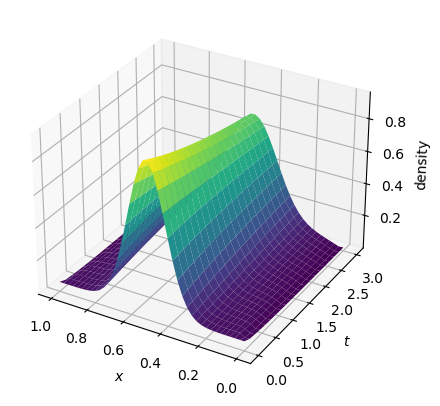

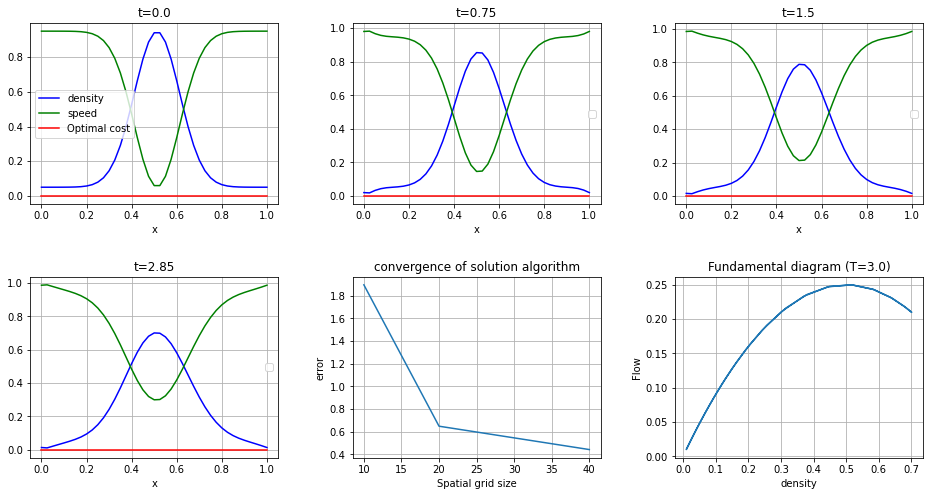

In [16]:
title1="\n Non Viscous MFG-NonSep"
fig1= 'Sol2_LWR_T3_N1_mu0.5__1.png'
fig2= 'Sol2_LWR_T3_N1_mu0.5__2.png'
plotting(title1,t_mfg,x_mfg,rho_mfg,u_mfg,V_mfg,Q_mfg,Nx_list,Error_list,fig1,fig2)